In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import gzip
from sklearn.inspection import permutation_importance
import seaborn as sns

In [2]:
# Function to load a gzipped model
def load_model(gzip_path):
    with gzip.GzipFile(gzip_path, "rb") as f:
            model = pickle.load(f)
    
    # with gzip.open(filename, 'rb') as f:
    #     model = joblib.load(f)
    return model

# Function to plot feature importances
def plot_feature_importances(importances, classifier_name, feature_names, top_n=20):
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:top_n]
    sorted_feature_names = [feature_names[i] for i in top_indices]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), importances[top_indices], align='center')
    plt.xticks(range(top_n), sorted_feature_names, rotation=90)
    plt.title(f'Top {top_n} Feature Importances - {classifier_name}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

In [3]:
classifiers = {
            "Logistic_Regression": 'Logistic_Regression_BE.sav.gz',
            "Gaussian_NB":'Gaussian_NB_BE.sav.gz',
            # "Bernoulli_NB":'Bernoulli_NB_BE.sav.gz',
            "Decision_Tree":'Decision_Tree_BE.sav.gz',
            "Random_Forest":'Random_Forest_BE.sav.gz',
            "Extra_Trees_Classifier":'Extra_Trees_Classifier_BE.sav.gz',
            "Ada_Boost":'Ada_Boost_BE.sav.gz',
            "Gradient_Boosting":'Gradient_Boosting_BE.sav.gz',
            "LightGBM":'LightGBM_BE.sav.gz',
            "Hist_GB":'Hist_GB_BE.sav.gz',
            "XGBoost":'XGBoost_BE.sav.gz',
}

In [28]:
response_data = pd.read_parquet('../data/processed/chrome/08_12_2022/test_set_featurized_response_BE.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow')

In [17]:
request_data = pd.read_parquet('../data/processed/firefox/08_12_2022/merged_data_featurized_request_BE.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow')

In [18]:
request_data

,comb_col_non_tracker,comb_col_tracker,accept-language_binary,tracestate_binary,accept-encoding_binary,authorization_binary,content-type_binary,x-youtube-client-version_binary,x-goog-visitor-id_binary,access-control-request-headers_binary,...,sec-ch-ua-model_binary,x-youtube-client-name_binary,traceparent_binary,dpr_binary,sec-fetch-dest_binary,x-client-data_binary,accept_binary,sec-fetch-mode_binary,httpMessageId,tracker
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,13,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,20,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,21,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,22,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836251,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,1,1,67,1
836252,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,1,1,78,1
836253,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,1,1,70,1
836254,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,75,1


In [29]:
response_data

,comb_col_non_tracker,comb_col_tracker,amp-access-control-allow-source-origin_binary,x-hubspot-correlation-id_binary,x-tt-trace-tag_binary,cdn-pullzone_binary,x-akamai-request-id_binary,requestid_binary,x-vcl-time-ms_binary,cross-origin-opener-policy_binary,...,cdn-uid_binary,x-served-by_binary,x-accel-expires_binary,request-context_binary,x-powered-by_binary,date_binary,content-security-policy_binary,x-request-id_binary,httpMessageId,tracker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,22,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,235,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,146,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,246,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,103,1
171740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,197,0
171741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,229,0
171742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,55,0


In [15]:
X = response_data.iloc[:, 2:-2]  # All columns except the last
y = response_data.iloc[:, -1]   # The last column
feature_names = X.columns.tolist()

NameError: name 'response_data' is not defined

In [19]:
X = request_data.iloc[:, 2:-2]  # All columns except the last
y = request_data.iloc[:, -1]   # The last column
feature_names = X.columns.tolist()

In [31]:
# # Load the models and plot feature importances
# for name, file in classifiers.items():
#     gzip_path = f"../models/chrome/08_12_2022/response/{file}"
#     clf = load_model(gzip_path)
#     if hasattr(clf, 'feature_importances_'):
#         importances = clf.feature_importances_
#         plot_feature_importances(importances, name, feature_names)
#     else:
#         # Calculate permutation importance
#         result = permutation_importance(clf, X, y, n_repeats=10, random_state=10, n_jobs=-1)
#         importances = result.importances_mean
#         plot_feature_importances(importances, name, feature_names)

KeyboardInterrupt: 

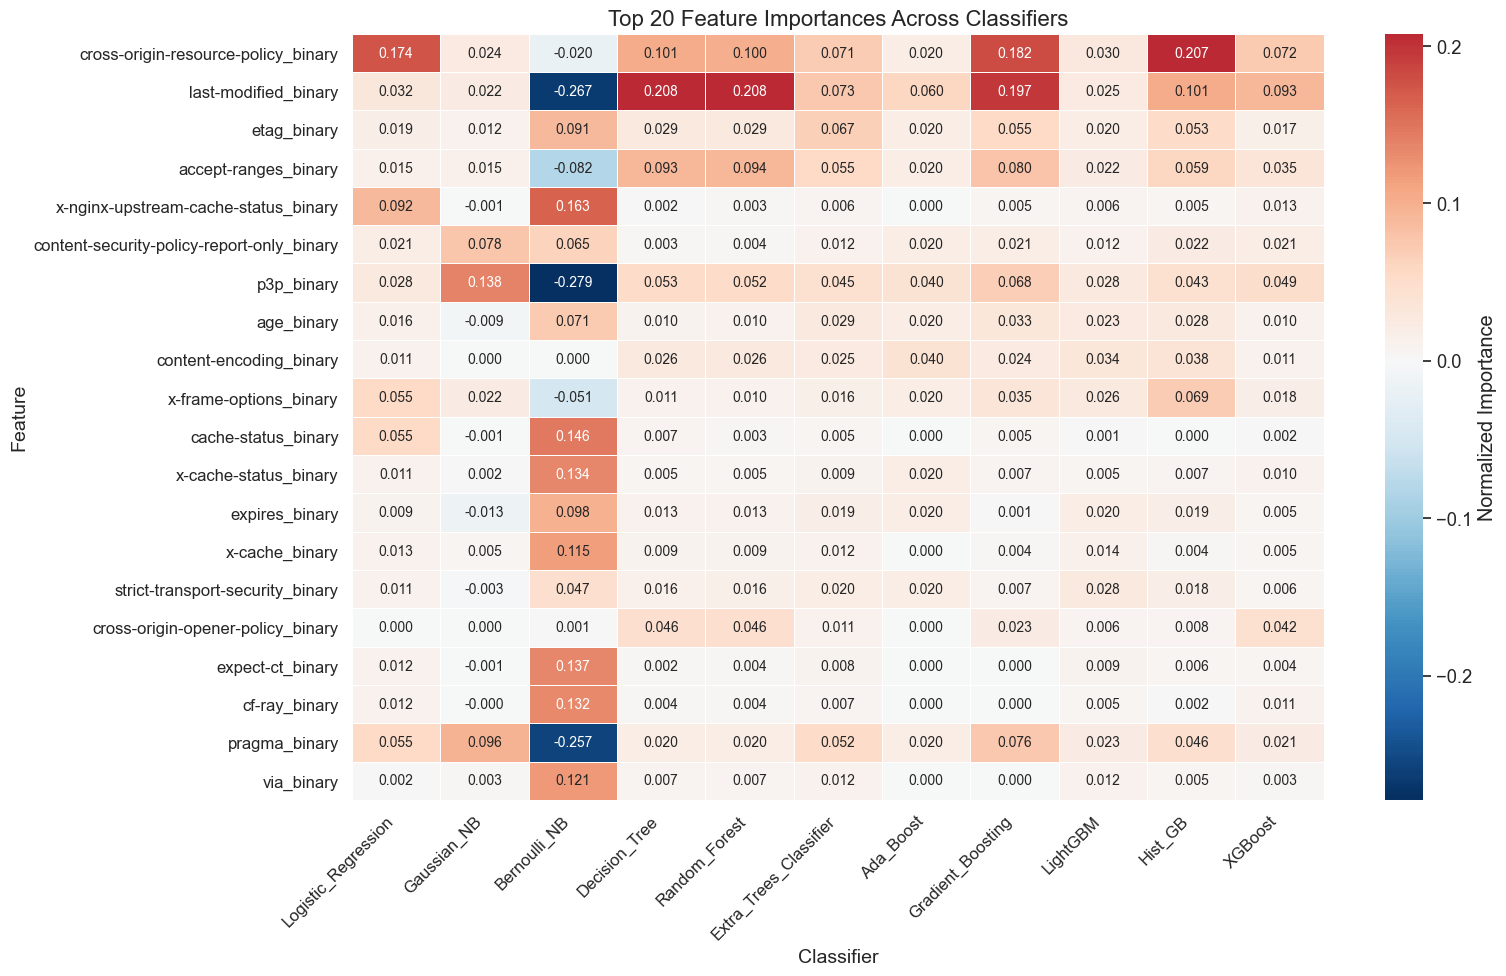

In [25]:
# # Plot heatmap with a diverging color palette
# plt.figure(figsize=(16, 10))
# sns.set(font_scale=1.2)
# heatmap = sns.heatmap(
#     feature_importances_top_df,
#     annot=True,
#     cmap='RdBu_r',
#     center=0,
#     linewidths=.5,
#     cbar_kws={'label': 'Normalized Importance'},
#     fmt='.3f',
#     annot_kws={"size": 10}
# )
# heatmap.set_title('Top 20 Feature Importances Across Classifiers', fontsize=16)
# heatmap.set_xlabel('Classifier', fontsize=14)
# heatmap.set_ylabel('Feature', fontsize=14)
# plt.xticks(rotation=45, ha='right', fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# plt.savefig('feature_importances_heatmap.pdf', format='pdf')
# plt.show()

In [20]:
%%time
# Initialize a DataFrame to hold feature importances
feature_importances_dict = {name: pd.Series(dtype=float) for name in classifiers}

# Load the models and compute feature importances
for name, file in classifiers.items():
    gzip_path = f"../models/chrome/08_12_2022/request/{file}" # do not forget to change filename to response or request 
    clf = load_model(gzip_path)
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    else:
        # Calculate permutation importance
        result = permutation_importance(clf, X, y, n_repeats=10, random_state=10, n_jobs=-1)
        importances = result.importances_mean
    
    # Normalize importances
    importances_normalized = importances / np.sum(importances)
    
    # Store in dictionary
    feature_importances_dict[name] = pd.Series(importances_normalized, index=feature_names)

# Combine top features from all classifiers
combined_features = pd.concat(feature_importances_dict.values()).groupby(level=0).sum()
top_combined_features = combined_features.nlargest(20).index

/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 9.43 s, sys: 3.94 s, total: 13.4 s
Wall time: 3min 58s


In [21]:
top_combined_features = combined_features.nlargest(10).index

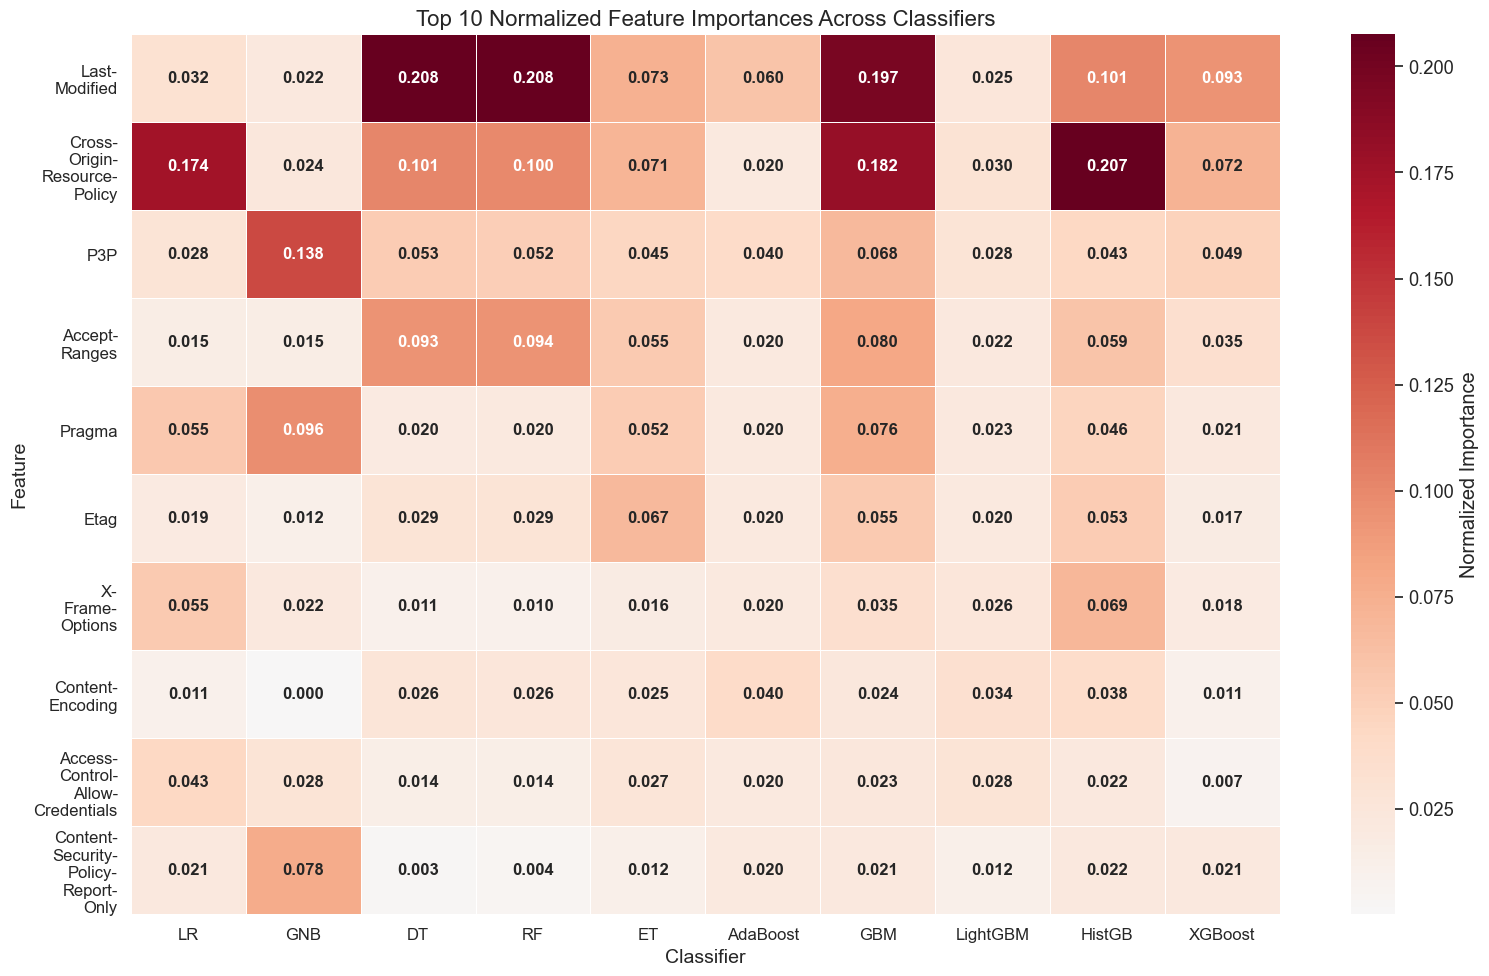

In [51]:
# Create DataFrame for heatmap
feature_importances_top_df = pd.DataFrame({name: feature_importances_dict[name].reindex(top_combined_features).fillna(0) for name in classifiers})

# Function to insert a newline character after each '-'
def insert_line_breaks(text):
    return text.replace('-', '-\n')

# Transform feature names for display and add line breaks for long names
feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()
feature_importances_top_df.index = feature_importances_top_df.index.map(insert_line_breaks)

# feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()



# Plot heatmap with a diverging color palette
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(
    feature_importances_top_df,
    annot=True,
    cmap='RdBu_r',
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Normalized Importance'},
    fmt='.3f',
    annot_kws={"size": 12, "weight": "bold"}
)
custom_labels = ["LR", "GNB", "DT", "RF", "ET", "AdaBoost", "GBM", "LightGBM", "HistGB", "XGBoost"]

heatmap.set_title('Top 10 Normalized Feature Importances Across Classifiers', fontsize=16)
heatmap.set_xlabel('Classifier', fontsize=14)
heatmap.set_ylabel('Feature', fontsize=14)
# plt.xticks(ticks=np.arange(len(custom_labels)), labels=custom_labels, rotation=90, ha='center', fontsize=12)
heatmap.set_xticklabels(custom_labels, rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig('request_performance_comparison.pdf', bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()
plt.savefig('feature_importances_heatmap.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

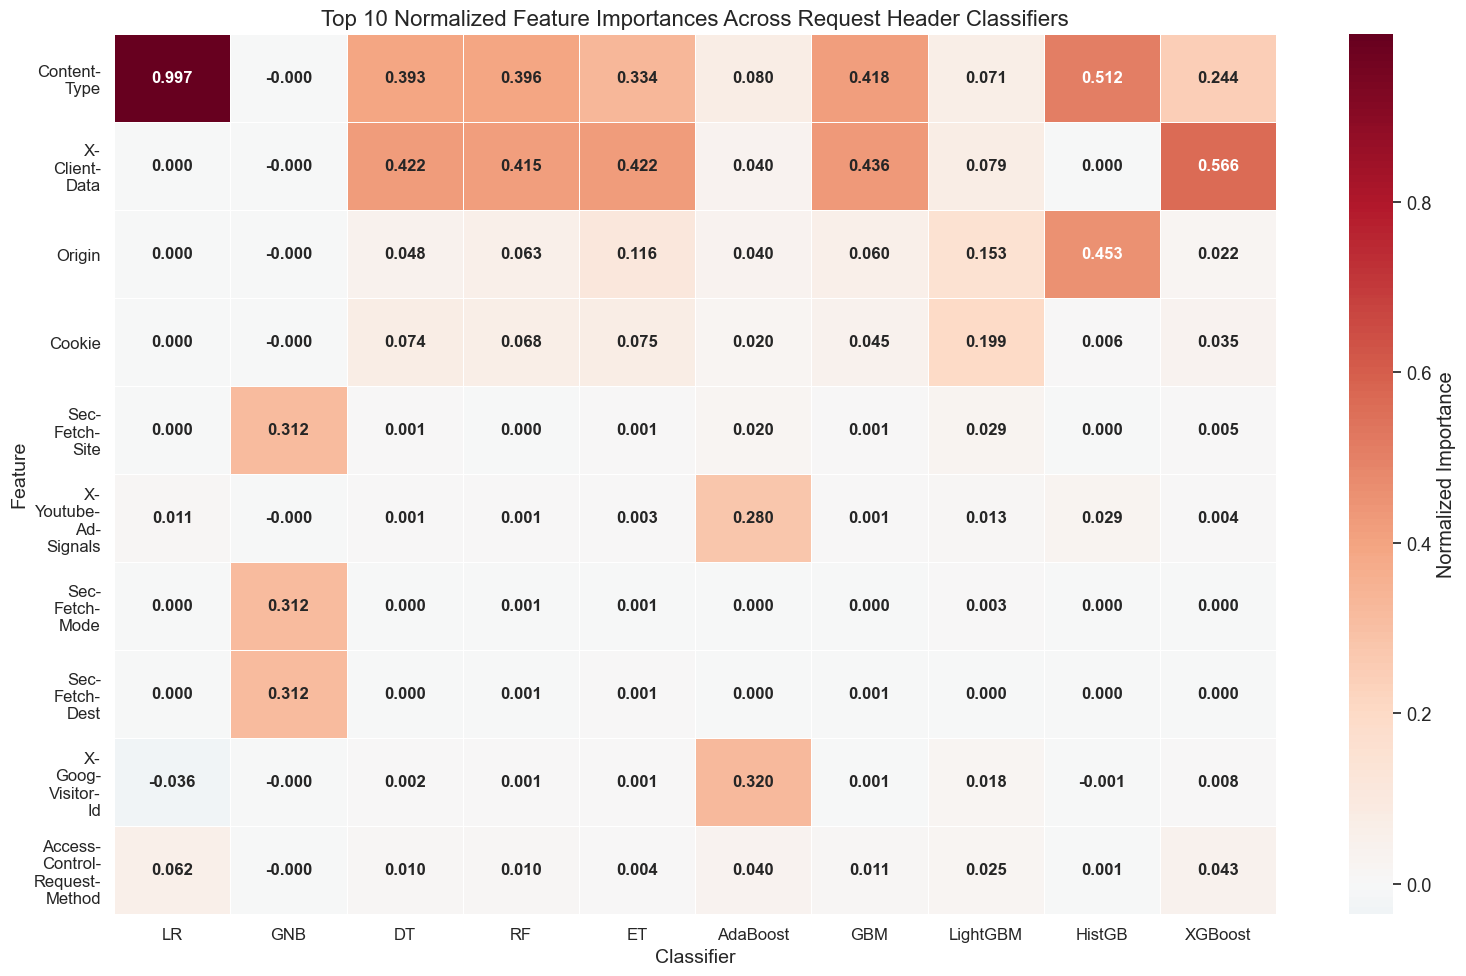

In [22]:
# Create DataFrame for heatmap
feature_importances_top_df = pd.DataFrame({name: feature_importances_dict[name].reindex(top_combined_features).fillna(0) for name in classifiers})

# Function to insert a newline character after each '-'
def insert_line_breaks(text):
    return text.replace('-', '-\n')

# Transform feature names for display and add line breaks for long names
feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()
feature_importances_top_df.index = feature_importances_top_df.index.map(insert_line_breaks)

# feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()



# Plot heatmap with a diverging color palette
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(
    feature_importances_top_df,
    annot=True,
    cmap='RdBu_r',
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Normalized Importance'},
    fmt='.3f',
    annot_kws={"size": 12, "weight": "bold"}
)
custom_labels = ["LR", "GNB", "DT", "RF", "ET", "AdaBoost", "GBM", "LightGBM", "HistGB", "XGBoost"]

heatmap.set_title('Top 10 Normalized Feature Importances Across Request Header Classifiers', fontsize=16)
heatmap.set_xlabel('Classifier', fontsize=14)
heatmap.set_ylabel('Feature', fontsize=14)
# plt.xticks(ticks=np.arange(len(custom_labels)), labels=custom_labels, rotation=90, ha='center', fontsize=12)
heatmap.set_xticklabels(custom_labels, rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig('request_performance_comparison.pdf', bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()
plt.savefig('feature_importances_heatmap_req.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

In [57]:
response_data[['cross-origin-resource-policy_binary', 'tracker']].groupby('tracker').count()

,cross-origin-resource-policy_binary
tracker,
0,120503
1,51241


In [58]:
gzip_path = f"../models/chrome/08_12_2022/response/LightGBM_BE.sav.gz"
clf = load_model(gzip_path)

In [60]:
clf.feature_importances_ / np.sum(clf.feature_importances_)

array([0.00566667, 0.00133333, 0.00366667, 0.00033333, 0.004     ,
       0.00033333, 0.00166667, 0.00633333, 0.        , 0.00466667,
       0.00233333, 0.001     , 0.00066667, 0.02566667, 0.022     ,
       0.017     , 0.00233333, 0.00266667, 0.00033333, 0.00033333,
       0.011     , 0.        , 0.        , 0.        , 0.00733333,
       0.        , 0.        , 0.00233333, 0.00633333, 0.        ,
       0.001     , 0.00133333, 0.00666667, 0.005     , 0.        ,
       0.00866667, 0.03366667, 0.00066667, 0.00266667, 0.001     ,
       0.00066667, 0.01033333, 0.02033333, 0.00033333, 0.001     ,
       0.001     , 0.02966667, 0.014     , 0.        , 0.        ,
       0.00433333, 0.002     , 0.00033333, 0.02      , 0.00166667,
       0.004     , 0.005     , 0.009     , 0.00566667, 0.00766667,
       0.001     , 0.00666667, 0.        , 0.        , 0.004     ,
       0.00033333, 0.00266667, 0.005     , 0.00033333, 0.009     ,
       0.001     , 0.01733333, 0.001     , 0.002     , 0.00833

### Frequency Plot

In [ ]:
chrome_old = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/merged_data.parquet.gzip", engine="pyarrow",
            dtype_backend="pyarrow"
)

chrome_new = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data.parquet.gzip', engine="pyarrow", dtype_backend="pyarrow")

firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/merged_data.parquet.gzip', engine="pyarrow",
            dtype_backend="pyarrow")

brave = pd.read_parquet('../data/processed/brave/08_12_2022/merged_data.parquet.gzip', engine="pyarrow",
            dtype_backend="pyarrow")

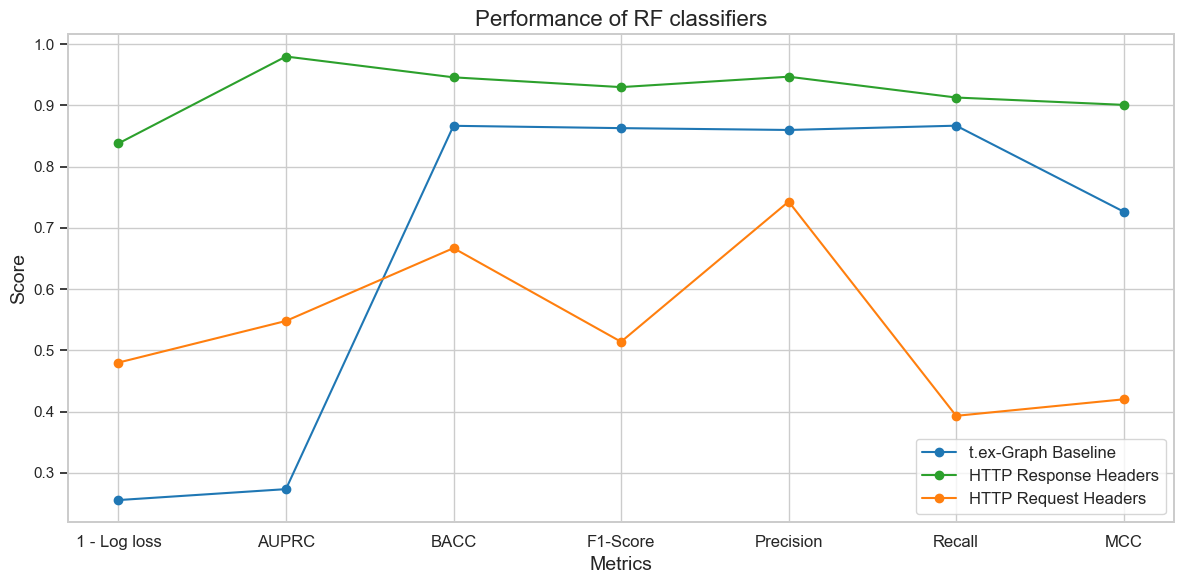

In [24]:
# Load the datasets
baseline_file_path = '../models/result_metrics/t.ex-Graph (FQDN)-pretty.csv'
http_response_file_path = '../models/result_metrics/chrome_08_12_2022_test_set_response.csv'
http_request_file_path = '../models/result_metrics/chrome_08_12_2022_test_set_request.csv'

baseline_data = pd.read_csv(baseline_file_path)
http_response_data = pd.read_csv(http_response_file_path)
http_request_data = pd.read_csv(http_request_file_path)

# Extracting Random Forest data for the three datasets
baseline_rf = baseline_data[baseline_data['t.ex-Graph (FQDN)'] == 'RandomForestClassifier']
http_response_rf = http_response_data[http_response_data['Unnamed: 0'] == 'Random_Forest']
http_request_rf = http_request_data[http_request_data['Unnamed: 0'] == 'Random_Forest']

# Select and rename columns for consistency
baseline_rf_selected = baseline_rf[['logloss', 'auprc', 'balanced_accuracy', 'f1_score', 'precision', 'recall', 'matthews_corrcoef']]
baseline_rf_selected.columns = ['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC']

http_response_rf_selected = http_response_rf[['test_log_loss', 'test_aupcr', 'test_balanced_accuracy', 'test_f1', 'test_precision', 'test_recall', 'test_mcc']]
http_response_rf_selected.columns = ['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC']

http_request_rf_selected = http_request_rf[['test_log_loss', 'test_aupcr', 'test_balanced_accuracy', 'test_f1', 'test_precision', 'test_recall', 'test_mcc']]
http_request_rf_selected.columns = ['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC']

# Combine data into a single dataframe
combined_data = {
    't.ex-Graph Baseline': baseline_rf_selected.iloc[0].values,
    'HTTP Response Headers': http_response_rf_selected.iloc[0].values,
    'HTTP Request Headers': http_request_rf_selected.iloc[0].values
}
combined_df = pd.DataFrame(combined_data, index=['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC'])

# Modify the combined dataframe
combined_df.loc['Log loss'] = 1 - combined_df.loc['Log loss']
combined_df.rename(index={'Log loss': '1 - Log loss', 'F1': 'F1-Score'}, inplace=True)

# Plotting the combined data with updated values and labels
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define the lines and colors for each version of Random Forest
colors = ['#1f77b4','#2ca02c','#ff7f0e']
labels = ['t.ex-Graph Baseline', 'HTTP Response Headers', 'HTTP Request Headers']

for label, color in zip(labels, colors):
    ax1.plot(combined_df.index, combined_df[label], marker='o', linestyle='-', label=label, color=color)

# Set labels, title, and legend for the primary axis
ax1.set_xlabel('Metrics', fontsize=14)
ax1.set_ylabel('Score', fontsize=14)
ax1.set_title('Performance of RF classifiers', fontsize=16)
ax1.set_xticks(np.arange(len(combined_df.index)))
ax1.set_xticklabels(combined_df.index, fontsize=12)
ax1.legend(fontsize=12, loc='lower right')

# Create a secondary y-axis to show the metrics
ax2 = ax1.twinx()
ax2.set_yticks([])  # Hide secondary y-axis ticks

# Improve layout
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('request_performance_comparison.pdf', bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.show()